## Тема: Градиентный бустинг. AdaBoost

In [1]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [2]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [76]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
    predictions = np.zeros(X.shape[0])
    for i, x in enumerate(X):
        prediction = 0
        for alg in trees_list:
            prediction += eta * alg.predict([x])[0]
        predictions[i] = prediction
        
#     predictions = np.array(
#         [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
#     )

    return predictions

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [6]:
def residual(y, z):
    return - (z - y)

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [8]:
# ИЗМЕНЕНО
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    
    train_prediction = gb_predict(X_train, trees, eta)
    mse_train = mean_squared_error(y_train, train_prediction)

    test_prediction = gb_predict(X_test, trees, eta)
    mse_test = mean_squared_error(y_test, test_prediction)
    

    return mse_train, mse_test

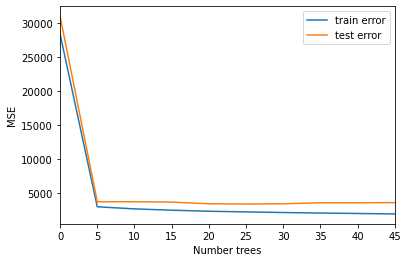

In [28]:
# ИЗМЕНЕНО

# Число деревьев в ансамбле
n_trees = [i for i in range(0, 46, 5)]

# Максимальная глубина деревьев
max_depth = 1

# Шаг
eta = 1

train_err = []
test_err = []

for j in n_trees:
    trees, train_errors, test_errors = gb_fit(j, max_depth, X_train, X_test, y_train, y_test, eta)
    ea = evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)
    train_err.append(ea[0])
    test_err.append(ea[1])
    
    
plt.xlabel('Number trees')
plt.ylabel('MSE')
plt.xlim(0, n_trees[-1])
plt.plot(n_trees, train_err, label='train error')
plt.plot(n_trees, test_err, label='test error')
plt.legend(loc='upper right')
plt.show()

In [27]:
df_trees = pd.DataFrame({'trees':n_trees, 'train_err':np.round(train_err, 2), 'test_err':np.round(test_err, 2)})
df_trees

,trees,train_err,test_err
0,0,28416.30,31037.17
1,5,2979.86,3719.13
2,10,2669.53,3725.40
3,15,2475.72,3671.65
4,20,2322.58,3422.88
5,25,2227.79,3390.47
6,30,2133.38,3421.68


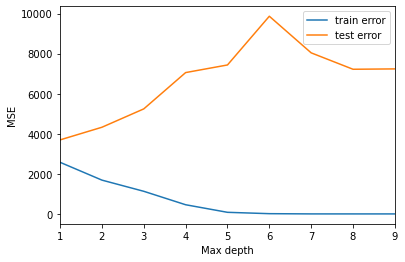

In [90]:
# Число деревьев в ансамбле
n_trees = 10

# Максимальная глубина деревьев
max_depth = [i for i in range(1, 10)]

# Шаг
eta = 1

train_err = []
test_err = []

for k in max_depth:
    trees, train_errors, test_errors = gb_fit(n_trees, k, X_train, X_test, y_train, y_test, eta)
    ea = evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)
    train_err.append(ea[0])
    test_err.append(ea[1])
    
    
plt.xlabel('Max depth')
plt.ylabel('MSE')
plt.xlim(1, max_depth[-1])
plt.plot(max_depth, train_err, label='train error')
plt.plot(max_depth, test_err, label='test error')
plt.legend(loc='upper right')
plt.show()

In [91]:
df_depth = pd.DataFrame({'max_depth':max_depth, 'train_err':np.round(train_err, 2), 'test_err':np.round(test_err, 2)})
df_depth

,max_depth,train_err,test_err
0,1,2575.47,3694.27
1,2,1686.83,4325.15
2,3,1128.83,5241.53
3,4,457.89,7053.40
4,5,79.89,7433.59
5,6,12.12,9865.00
6,7,0.63,8038.04
7,8,0.06,7219.02
8,9,0.00,7236.90


**Вывод:**  
    с увеличением количества деревьев в ансамбле происходит переобучение, точность модели немного ухудшается;  
    с увеличением максимальной глубины деверьев происходит сильное переобучение, точность модели ухудшается. 

### 2. *Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [120]:
def sgb_predict(X, trees_list, coef_list, eta):
    
    predictions = np.zeros(X.shape[0])
    for i, x in enumerate(X):
        prediction = 0
        for alg, coef in zip(trees_list, coef_list):
            prediction += eta * coef * alg.predict([x])[0]
        predictions[i] = prediction
        
#     predictions = np.array(
#         [sum([eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X]
#     )

    return predictions

In [124]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, size, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    np.random.seed(1)
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            
            ind = np.random.choice(range(0, len(X_train)), size)
            X_batch, y_batch = X_train[ind], y_train[ind]
            
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_batch, y_batch)
            
            train_errors.append(mean_squared_error(y_batch, sgb_predict(X_batch, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, sgb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = sgb_predict(X_batch, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_batch, residual(y_batch, target))
            
            train_errors.append(mean_squared_error(y_batch, sgb_predict(X_batch, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, sgb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [127]:
n_trees = 10
max_depth = 2
coefs = [1] * n_trees
size=len(X_train)//2
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

sgb_trees, sgb_train_errors, sgb_test_errors = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs,size, eta)

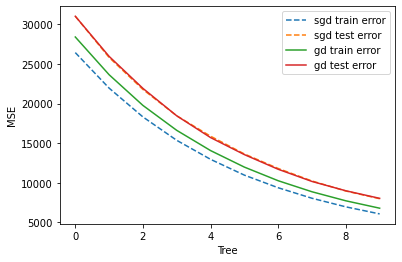

In [128]:
plt.xlabel('Tree')
plt.ylabel('MSE')
plt.plot(sgb_train_errors, label='sgd train error', linestyle='--')
plt.plot(sgb_test_errors, label='sgd test error', linestyle='--')
plt.plot(train_errors, label='gd train error')
plt.plot(test_errors, label='gd test error')
plt.legend(loc='upper right')
plt.show()